In [2]:
import numpy as np
import queue
import scipy.constants as spc
import matplotlib.pyplot as plt

In [23]:
SK = {
    ('s', 's'): lambda l, m, n, V: V['ss'],
    ('s', 'px'): lambda l, m, n, V:  l * V['sp'],
    ('px', 's'): lambda l, m, n, V: -l * V['sp'],

    ('s', 'py'): lambda l, m, n, V:  m * V['sp'],
    ('py', 's'): lambda l, m, n, V: -m * V['sp'],

    ('s', 'pz'): lambda l, m, n, V:  n * V['sp'],
    ('pz', 's'): lambda l, m, n, V: -n * V['sp'],

    ('px', 'px'): lambda l, m, n, V: l**2 * V['pp_sigma'] + (1 - l**2) * V['pp_pi'],
    ('py', 'py'): lambda l, m, n, V: m**2 * V['pp_sigma'] + (1 - m**2) * V['pp_pi'],
    ('pz', 'pz'): lambda l, m, n, V: n**2 * V['pp_sigma'] + (1 - n**2) * V['pp_pi'],

    ('px', 'py'): lambda l, m, n, V: l * m * (V['pp_sigma'] - V['pp_pi']),
    ('px', 'pz'): lambda l, m, n, V: l * n * (V['pp_sigma'] - V['pp_pi']),
    ('py', 'pz'): lambda l, m, n, V: m * n * (V['pp_sigma'] - V['pp_pi']),

    ('py', 'px'): lambda l, m, n, V: l * m * (V['pp_sigma'] - V['pp_pi']),
    ('pz', 'px'): lambda l, m, n, V: l * n * (V['pp_sigma'] - V['pp_pi']),
    ('pz', 'py'): lambda l, m, n, V: m * n * (V['pp_sigma'] - V['pp_pi']),
}

Vss = -8.13
Vsp = 5.88
Vxx=1.71
Vxy=7.51

V_ss_sigma = Vss / 4
V_sp_sigma = np.sqrt(3) / 4 * Vsp
diff1 = Vxx - Vxy
diff2 = Vxx
V_pp_pi = diff1 / 4
V_pp_sigma = (Vxy + 4 * V_pp_pi /3) * 3 / 4
a=1
hbar = spc.hbar
Es,Ep =  -4.03, 3.17
Esp3 = 18
E = {'s': Es, 'px': Ep, 'py': Ep, 'pz': Ep,'sp3':Esp3}
V = {
    'ss': V_ss_sigma,
    'sp': V_sp_sigma,
    'pp_sigma': V_pp_sigma,
    'pp_pi': V_pp_pi
}

Es = E['s']
Ep = E['px']             

# orbital-basis Hamiltonian
H_orb = np.diag([Es, Ep, Ep, Ep])

# change-of-basis matrices
U_orb_to_sp3 = 0.5*np.array([[1, 1, 1, 1],
                             [1, 1,-1,-1],
                             [1,-1, 1,-1],
                             [1,-1,-1, 1]])
U_sp3_to_orb = U_orb_to_sp3.T  

a = (Es + 3*Ep)/4.0
b = (Es -   Ep)/4.0
H_sp3_explicit = np.full((4,4), b)
np.fill_diagonal(H_sp3_explicit, a)


# sp3 basis
print(H_sp3_explicit)
# orbital basis 
print(U_orb_to_sp3 @ H_sp3_explicit @ U_orb_to_sp3.T)

[[ 1.37 -1.8  -1.8  -1.8 ]
 [-1.8   1.37 -1.8  -1.8 ]
 [-1.8  -1.8   1.37 -1.8 ]
 [-1.8  -1.8  -1.8   1.37]]
[[-4.03  0.    0.    0.  ]
 [ 0.    3.17  0.    0.  ]
 [ 0.    0.    3.17  0.  ]
 [ 0.    0.    0.    3.17]]


In [24]:
class Atom:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

    def __eq__(self, other):
        if isinstance(other, Atom):
            return self.x == other.x and self.y == other.y and self.z == other.z
        return False
    

    def __hash__(self):
        return hash((self.x, self.y, self.z))

    def __repr__(self):
        return f"Atom({self.x}, {self.y}, {self.z})"
    

class UnitCellGeneration:
    _DELTAS = {                       
        0: [(+0.25,+0.25,+0.25), (+0.25,-0.25,-0.25),
            (-0.25,+0.25,-0.25), (-0.25,-0.25,+0.25)],   # type-0 sub-lattice
        1: [(-0.25,-0.25,-0.25), (-0.25,+0.25,+0.25),
            (+0.25,-0.25,+0.25), (+0.25,+0.25,-0.25)]    # type-1 sub-lattice
    }
    
    
    @staticmethod
    def _delta(a, b):   
        return (b.x - a.x, b.y - a.y, b.z - a.z)

    @staticmethod
    def _sublattice(atom):    
        return (round(atom.x*4) + round(atom.y*4) + round(atom.z*4)) & 1
    

    def __init__(self, N):
        self.atoms = {}      # basic graph design 
        self.visited = set() # dfs
        self.N = N
        # base node 
        self.addAtoms(Atom(0, 0, 0), 0)
        self.periodicityFix = {}
        self.atoms_nonPeriodic = self.atoms.copy()

        for atom in self.atoms:
            
            listofatoms = self.atoms[atom]
            for i in listofatoms:
              
                value = i
                if not self.checkIfAllowed(value):
                    # we need to update the periodic neighbor
                    delta = (value.x - atom.x, value.y - atom.y, value.z - atom.z)
                    try:
                        newNeighbor = Atom((atom.x + delta[0]) % 1, (atom.y + delta[1]) % 1, (atom.z + delta[2]))
                        self.atoms[newNeighbor].append(atom)
                       
                    except:
                        print(atom, value, newNeighbor)
                        return 
                    
            

            self.atoms[atom] = list(filter(self.checkIfAllowed, self.atoms[atom]))
            


    def checkIfAllowed(self, newAtom):
        # check if atoms are in proper cell 
        return not (newAtom.x < 0 or newAtom.y < 0 or newAtom.z < 0 or newAtom.z >= self.N or newAtom.x >= 1 or newAtom.y >= 1)
        
    def checkIfAllowedInZDirection(self, newAtom):
        return not (newAtom.z < 0 or newAtom.z >= self.N)

    def addAtoms(self, base, atomType):
        # dfs 
        if base in self.visited:
            return
        self.visited.add(base)

        if atomType == 0:
            atom1 = Atom(base.x + 0.25, base.y + 0.25, base.z + 0.25)
            atom2 = Atom(base.x + 0.25, base.y - 0.25, base.z - 0.25)
            atom3 = Atom(base.x - 0.25, base.y + 0.25, base.z - 0.25)
            atom4 = Atom(base.x - 0.25, base.y - 0.25, base.z + 0.25)
        elif atomType == 1:
            atom1 = Atom(base.x - 0.25, base.y - 0.25, base.z - 0.25)
            atom2 = Atom(base.x - 0.25, base.y + 0.25, base.z + 0.25)
            atom3 = Atom(base.x + 0.25, base.y - 0.25, base.z + 0.25)
            atom4 = Atom(base.x + 0.25, base.y + 0.25, base.z - 0.25)
        else:
            return

        newAtoms = [atom1, atom2, atom3, atom4]
        
        for newAtom in newAtoms:
            
            # If base has no neighbors yet, initialize its neighbor list.
            if self.checkIfAllowedInZDirection(newAtom):
                if base not in self.atoms:
                    self.atoms[base] = [newAtom]
                elif newAtom not in self.atoms[base]:
                    self.atoms[base].append(newAtom)
            
            # Recursively add neighbors (DFS)
            if self.checkIfAllowed(newAtom):
                self.addAtoms(newAtom, (atomType + 1) % 2)
                


    def neighborTable(self): # finds the directional cosines: 
        neighborInformation = {}
        for atom in self.atoms:
            neighborInformation[atom] = {}
            for i in range(len(self.atoms[atom])):
                nonPeriodicNeighbor = self.atoms_nonPeriodic[atom][i]
     
                # Compute the difference vector between neighbor and atom.
                dx = nonPeriodicNeighbor.x - atom.x
                dy = nonPeriodicNeighbor.y - atom.y
                dz = nonPeriodicNeighbor.z - atom.z
                
                delta = (dx, dy, dz)
                newNeighbor = Atom((atom.x + delta[0]) % 1, (atom.y + delta[1]) % 1, (atom.z + delta[2]))
                norm = np.sqrt(dx**2 + dy**2 + dz**2)
                
                # Calculate the directional cosines: l, m, n.
                if norm != 0:
                    l = dx / norm
                    m = dy / norm
                    n = dz / norm
                else:
                    l, m, n = 0.0, 0.0, 0.0
                
                neighborInformation[atom].update({newNeighbor: (delta, l, m, n)})
        
        return neighborInformation
    
    
    def dangling_bonds(self, atom):
        """
        Return the list of bond-direction vectors that *should* exist for
        `atom` but do not (because the neighbour lies outside the slab).
        """
        missing = []
        for dx, dy, dz in self._DELTAS[self._sublattice(atom)]:
            nx, ny, nz = atom.x + dx, atom.y + dy, atom.z + dz

            # check if it is outside the cell in z direction 
            if nz < 0 or nz >= self.N:
                missing.append((dx, dy, dz))
                continue

            n_atom = Atom(nx % 1, ny % 1, nz)   # wrap in x, y (periodic)
            if n_atom not in self.atoms:        
                missing.append((dx, dy, dz))

        return missing     
    
    def determine_hybridization(signs):
        # Extract just the signs
        sign_pattern = np.sign(signs)
        
        # Ensure first sign (s orbital) is positive for consistent comparison
        if sign_pattern[0] < 0:
            sign_pattern = -sign_pattern
        
        # Map each sign pattern to its hybridization index
        if np.array_equal(sign_pattern, [1, 1, 1, 1]):       # Type a
            return 0
        elif np.array_equal(sign_pattern, [1, 1, -1, -1]):   # Type b
            return 1
        elif np.array_equal(sign_pattern, [1, -1, 1, -1]):   # Type c
            return 2
        elif np.array_equal(sign_pattern, [1, -1, -1, 1]):   # Type d
            return 3
        
        return None 
        
        
    def __str__(self):
        s = ""
        for atom, neighbors in self.atoms.items():
            s += "f{atom} -> {neighbors}" + "\n"
    
    

N = 1  # how tall
unit_cell = UnitCellGeneration(N)

print(unit_cell)
print(unit_cell.dangling_bonds(Atom(0,0,0)))



TypeError: __str__ returned non-string (type NoneType)

In [25]:

def create_tight_binding(k, N, potentialProfile):
    kx,ky,kz = k
    unitCell = UnitCellGeneration(N)
    unitNeighbors = unitCell.neighborTable()
    numberOfAtoms = len(unitNeighbors.keys())
    size = numberOfAtoms* 4 # sp3
    A = np.zeros((size, size), dtype=complex)    
    
    atomToIndex = {}
    indexToAtom = {}
    for atom_index,atom in enumerate(unitNeighbors):
        atomToIndex[atom] = atom_index
        indexToAtom[atom_index] = atom
    
  
    orbitals = ['s', 'px', 'py', 'pz']
    
    # old code with no dangling bonds 
    """for atom_index in range(numberOfAtoms):
        for orbIndex, orbital in enumerate(orbitals):
            index = atom_index * 4 + orbIndex
            #print(orbital)
            A[index, index] += E[orbital]"""

            
    for atom_idx, atom in indexToAtom.items():
        hybridizationMatrix = H_sp3_explicit.copy() 

        for delta in unitCell.dangling_bonds(atom):
            signs = np.array([1/4] + list(delta)) * 4
            h = UnitCellGeneration.determine_hybridization(signs)
            hybridizationMatrix[h, h] += E['sp3']          # increase the energy of dangling states 
        
        # if there are no dangling bonds this returns the standard diag matrix with onsite energies 
        onsiteMatrix = U_orb_to_sp3 @ hybridizationMatrix @ U_orb_to_sp3.T # go back to orbital basis 
        A[atom_idx*4:(atom_idx+1)*4, atom_idx*4:(atom_idx+1)*4] = onsiteMatrix
    
    for atom_index in range(numberOfAtoms):
        atom = indexToAtom[atom_index]
        neighbors = unitNeighbors[atom]
        for orbitalIndex, orbital in enumerate(orbitals):
            index_i = atom_index * 4 + orbitalIndex
            
            effectiveZinPotential = int(atom.z)
            
            A[index_i,index_i] += potentialProfile[effectiveZinPotential]
            
            for neighbor in neighbors.keys():
                delta = neighbors[neighbor][0]
                l,m,n = neighbors[neighbor][1:]
                phase = np.exp(1j * (kx*delta[0] + ky*delta[1])) # blochs theorem does not work 
                
                neighbor_index = atomToIndex[neighbor]       
                
                for secOrbitalIndex, secondOrbital in enumerate(orbitals):
                    index_j = neighbor_index * 4 + secOrbitalIndex
                    
                    hop = SK[(orbital, secondOrbital)](l, m, n, V)
                        
                    A[index_i,index_j] += hop * phase   
            
                
        dagger = lambda A: np.conjugate(A.T)
    if not np.allclose(A, dagger(A)):
        print("H isnt Hermitian")

    eigvals,eigv = np.linalg.eigh(A)
    return eigvals, eigv, A
    

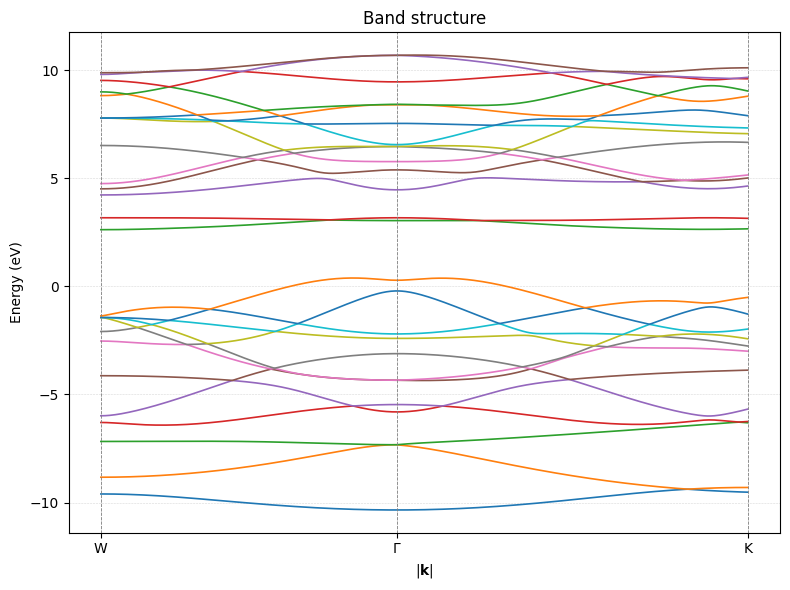

In [26]:
import numpy as np
import matplotlib.pyplot as plt


class BandStructurePlotter:
    """
    Convenience wrapper for
        1) generating a high-symmetry k-path,
        2) computing the tight-binding eigen-energies,
        3) plotting them with optional masking (e.g. remove H surface states).

    Parameters
    ----------
    N : int
        Number of conventional unit cells along z (finite direction).
    potential_profile : 1-d array length N+1
        On-site electrostatic potential versus z-layer.
    """
    # ---------- construction ----------
    def __init__(self, N: int, potential_profile: np.ndarray):
        self.N = N
        self.V = np.asarray(potential_profile)
        # to be filled later
        self.k_path = None
        self.k_ticks = None          # dict {label: index}
        self.energies = None         # shape (Nk, Nb)

    # ---------- k-space utilities ----------
    @staticmethod
    def _cumulative_distance(k_path):
        d = np.zeros(len(k_path))
        for i in range(1, len(k_path)):
            d[i] = d[i-1] + np.linalg.norm(k_path[i] - k_path[i-1])
        return d

    @staticmethod
    def _segment(a, b, n):
        """n points from a→b (excluding b)."""
        return np.linspace(a, b, n, endpoint=False)

    def build_k_path(self, corner_points, points_per_segment=200):
        """
        corner_points : list of 3-vectors (in Cartesian reciprocal space)
            e.g. [W, Γ, K, …].
        """
        k = []
        for p, q in zip(corner_points[:-1], corner_points[1:]):
            k.extend(self._segment(p, q, points_per_segment))
        k.append(corner_points[-1])          # include the last corner exactly
        self.k_path = np.array(k)
        self.k_ticks = {lbl: i*points_per_segment
                        for i, lbl in enumerate("".join((" " * (len(corner_points)-1))).split())}

    # ---------- eigenproblem ----------
    def _compute_band_structure(self):
        assert self.k_path is not None, "call build_k_path() first"
        Nk = len(self.k_path)
        # get one eigen-spectrum just to know how many bands
        test_E = create_tight_binding(self.k_path[0], self.N, self.V)[0]
        Nb = test_E.size
        self.energies = np.empty((Nk, Nb))
        for i, kvec in enumerate(self.k_path):
            self.energies[i] = np.sort(create_tight_binding(kvec, self.N, self.V)[0].real)

    # ---------- master plot ----------
    def plot(self, energy_window=None, colour_cycle=None,
             k_labels=None, linewidth=1.2, figsize=(8, 6)):
        """
        energy_window : (Emin, Emax) tuple or None
            Energies outside are masked out (useful to hide surface bands).
        k_labels : dict {label: index} or None
            Override tick labels.  If None, W-Γ-K… order is auto-generated.
        """
        if self.energies is None:
            self._compute_band_structure()

        # x-axis
        k_x = self._cumulative_distance(self.k_path)

        # optional masking
        E = self.energies.copy()
        if energy_window is not None:
            Emin, Emax = energy_window
            E[(E < Emin) | (E > Emax)] = np.nan

        # plotting
        plt.figure(figsize=figsize)
        if colour_cycle:
            plt.gca().set_prop_cycle(color=colour_cycle)

        for band in range(E.shape[1]):
            plt.plot(k_x, E[:, band], lw=linewidth)

        # decorations
        plt.ylabel("Energy (eV)")
        plt.xlabel("$|\\mathbf{k}|$")
        plt.title("Band structure")
        plt.grid(True, ls="--", lw=0.4, alpha=0.5)

        # ticks at high-symmetry points
        if k_labels is None and self.k_ticks:
            k_labels = self.k_ticks
        if k_labels:
            tick_pos = [k_x[idx] for idx in k_labels.values()]
            for x in tick_pos:
                plt.axvline(x, color='grey', ls='--', lw=0.6)
            plt.xticks(tick_pos, list(k_labels.keys()))

        plt.tight_layout()
        plt.show()
# ----------- high-symmetry points (cartesian reciprocal coords) -----------
a = 1.0
G  = np.array([0, 0, 0])
W  = 2*np.pi/a * np.array([1/2, 1/2, 0])
K  = 2*np.pi/a * np.array([3/4, 3/8, 0])

# ----------- build, run, plot -----------
N  = 1
plotter = BandStructurePlotter(N, potential_profile=np.zeros(N+1))
plotter.build_k_path([W, G, K], points_per_segment=200)

# custom tick dictionary (same indices you used before)
plotter.plot(energy_window=(-12, 12),
             k_labels={'W': 0,
                       r'$\Gamma$': 200,
                       'K': 400})


In [ ]:
import numpy as np

hbar = 1.054_571_817e-34   # J·s
a = 1.0                    # lattice parameter, *must* match your TB code
N = 10                      # slab thickness


def effective_mass(potential_profile, klen=25):
    """
    Returns the curvature   d²E/dk_x²   at the minimum of the conduction band
    (Gamma valley in a symmetric slab) and the corresponding effective mass

           m* = ħ² / (d²E/dk²)

    in the same energy / k units used by `create_tight_binding`.
    """
    # k grid
    k_grid = np.linspace(-1, 1, klen) * 2*np.pi/a
    dk = k_grid[1] - k_grid[0]

    #number of bands
    nbands = len(create_tight_binding(np.array([0, 0, 0]), N, potential_profile)[0])

    # store energies in this
    energies = np.empty((klen * klen, nbands))

    idx = 0
    for kx in k_grid:
        for ky in k_grid:
            E = create_tight_binding(np.array([kx, ky, 0]), N, potential_profile)[0].real
            energies[idx] = np.sort(E)
            idx += 1

    energies = energies.reshape(klen, klen, nbands)   # (kx, ky, band)
    cond_band = energies[:, :, nbands // 2]           # conduction-band surface  (klen × klen)

    # find min
    kx_min, ky_min = np.unravel_index(cond_band.argmin(), cond_band.shape)

    # boundary check
    if kx_min in (0, klen-1):
        raise RuntimeError("Band minimum on the BZ edge; need PBC-aware derivative.")

    # 2nd deriative
    d2E_dkx2 = (cond_band[kx_min-1, ky_min] +
                cond_band[kx_min+1, ky_min] -
                2*cond_band[kx_min,   ky_min]) / dk**2

    m_eff = hbar**2 / d2E_dkx2
    return m_eff, d2E_dkx2, (kx_min, ky_min)


pot_profile = np.zeros(N+1)
m_star, curvature, k_min = effective_mass(pot_profile)

print(f"Min at grid point {k_min}")
print(f"d²E/dk²  = {curvature:.4e}  (energy·length²)")
print(f"m*       = {m_star:.4e}")


Min at grid point (np.int64(6), np.int64(6))
d²E/dk²  = 4.8231e-01  (energy·length²)
m*       = 2.3058e-68


In [28]:
# broken 

def getTheDOS(E, N, sigma):
    def gaussian(En):
        return 1 / np.sqrt(2 * np.pi * sigma) * np.exp(-(E - En)**2 / (2 * sigma))
    D = 0
    for kx in np.linspace(-1,1,50):
        kx = 2 *np.pi / a * kx
        for ky in np.linspace(-1,1,50):
                energies = create_tight_binding(np.array([kx, ky, 0]), N, potentialProfile)[0]
                for en in energies:
                    D += gaussian(en)
            
    
    return D
        

def getFermiLevel(N, dos, dosE):
    kbT = 0.0257   
    fermi = lambda x: 1.0 / (1.0 + np.exp(x / kbT))
    
    def integralGuess(x):
        dE = dosE[1] - dosE[0]
    
        occupancy = fermi(dosE - x)  
    
        return dE * np.sum(dos * occupancy)
    
    numberOfElectrons = 4 * N * 8

    E_F = 0.55
    err = integralGuess(E_F) - numberOfElectrons

    step = 0.01
    while abs(err) > 2.0:
        if err < 0:

            E_F -= step
        else:
            E_F += step
        
        err = integralGuess(E_F) - numberOfElectrons
    
    return E_F

    